In [2]:
import os
import re
import joblib
from tqdm.auto import tqdm
from glob import glob

import pandas as pd
import numpy as np
import sklearn

import librosa
import torch
import torchaudio
import torchaudio.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/home/yyeon/anaconda3/envs/DL_Server/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [3]:
import IPython.display as ipd
import librosa.display

In [4]:
data_dir = './dataset'
train_data_dir = './dataset/train'
test_data_dir = './dataset/test'


train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
sub_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [5]:
train_df['path'] = train_df.apply(lambda x: os.path.join(train_data_dir, x['accent'].lower(), x['id']), axis=1)

In [6]:
train_df.head()

,id,accent,path
0,common_voice_en_10047.wav,Africa,./dataset/train/africa/common_voice_en_10047.wav
1,common_voice_en_10048.wav,Africa,./dataset/train/africa/common_voice_en_10048.wav
2,common_voice_en_10049.wav,Africa,./dataset/train/africa/common_voice_en_10049.wav
3,common_voice_en_10050.wav,Africa,./dataset/train/africa/common_voice_en_10050.wav
4,common_voice_en_10051.wav,Africa,./dataset/train/africa/common_voice_en_10051.wav


# Torch Audio

In [7]:
a,b = torchaudio.load(train_df['path'][14834])
print(a.shape)

torch.Size([1, 221184])


In [9]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

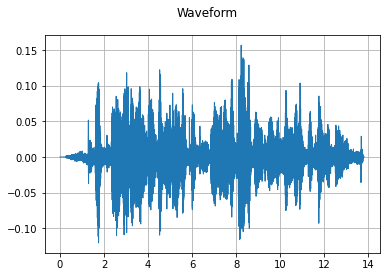

In [10]:
plot_waveform(a, sample_rate=16000)

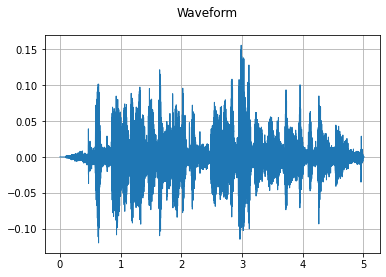

In [11]:
resample_a = T.Resample(orig_freq=44100, new_freq=16000)(a)
plot_waveform(resample_a, sample_rate=16000)

In [45]:


mel = torch.nn.Sequential(T.MelSpectrogram(n_fft=512,
                                           win_length=400,
                                           hop_length=160,
                                           n_mels=64),
                          T.AmplitudeToDB()
                         )

mel2 = torch.nn.Sequential(T.MelSpectrogram(n_fft=256,
                                            win_length=200,
                                            hop_length=160,
                                            n_mels=64),
                          T.AmplitudeToDB()
                         )

mel(a).shape

torch.Size([1, 64, 1383])

# EDA

<AxesSubplot:>

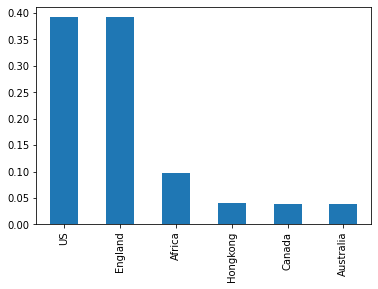

In [12]:
train_df['accent'].value_counts(normalize=True).plot(kind='bar')

In [13]:
train_df['accent'].value_counts()

US           10000
England      10000
Africa        2500
Hongkong      1020
Canada        1000
Australia     1000
Name: accent, dtype: int64

(80249,) 16000


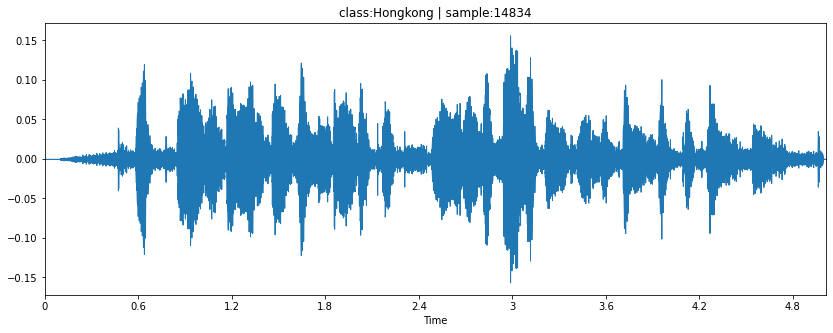

In [43]:
# sample = np.random.randint(20000)
sample = 14834
file_path = train_df['path'][sample]


plt.figure(figsize=(14, 5))
plt.title(f"class:{train_df['accent'][sample]} | sample:{sample}")

# sample_rate defines how many times per second a sound is sampled
data, sample_rate = librosa.load(file_path, sr=16000)
print(data.shape, sample_rate)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(data, rate=sample_rate)

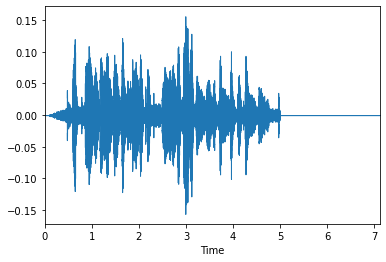

In [44]:
data = librosa.util.fix_length(data, 113900)
librosa.display.waveplot(data, sr=16000)
ipd.Audio(data, rate=16000)

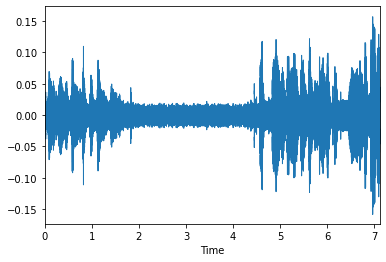

In [47]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, FrequencyMask, TimeMask
import numpy as np

SAMPLE_RATE = 16000

augmenter = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     PitchShift(min_semitones=-4, max_semitones=10, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])


# data, sample_rate = librosa.load(file_path, sr=16000)
aug_data = augmenter(samples=data, sample_rate=SAMPLE_RATE)
librosa.display.waveplot(aug_data, sr=16000)
ipd.Audio(aug_data, rate=16000)

In [53]:
S = librosa.feature.melspectrogram(y=aug_data,
                                         sr = 16000,
                                         n_fft=512,
                                         win_length=400,
                                         hop_length=160,
                                         n_mels=64)

In [54]:
m = librosa.power_to_db(S, ref=np.max)
m

array([[-25.51086  , -24.719828 , -29.630932 , ..., -17.174995 ,
        -15.704121 , -18.699024 ],
       [-23.585314 , -18.473705 , -25.722027 , ...,  -5.501442 ,
         -5.9881134,  -9.437464 ],
       [-25.675823 , -19.825712 , -30.133512 , ...,  -7.1141634,
         -8.203442 , -13.310729 ],
       ...,
       [-42.580696 , -39.385857 , -37.954292 , ..., -39.246902 ,
        -36.463833 , -39.614758 ],
       [-39.575253 , -36.672882 , -37.989017 , ..., -37.657223 ,
        -38.12064  , -39.9738   ],
       [-38.001995 , -40.654564 , -40.171486 , ..., -38.427567 ,
        -39.715233 , -40.713333 ]], dtype=float32)

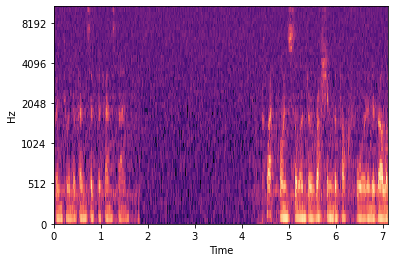

In [49]:
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=16000, hop_length=160, x_axis='time')

In [27]:
S2 = librosa.power_to_db(S, ref=np.max)
S2

array([[-16.914282 , -17.960598 , -20.494028 , ..., -20.738798 ,
        -22.83764  , -20.849468 ],
       [-11.613967 ,  -6.4407077,  -7.038598 , ...,  -8.21339  ,
         -8.074403 ,  -7.302431 ],
       [ -6.483896 ,  -7.497144 ,  -8.282161 , ...,  -9.017958 ,
         -8.282027 ,  -8.171325 ],
       ...,
       [-47.25152  , -48.42076  , -46.639698 , ..., -47.249672 ,
        -48.46316  , -46.328724 ],
       [-44.590546 , -44.946793 , -45.746674 , ..., -45.252396 ,
        -46.313484 , -44.60904  ],
       [-49.2336   , -46.756805 , -49.0049   , ..., -47.382095 ,
        -48.024776 , -48.331596 ]], dtype=float32)

In [34]:
d = np.array([])

In [ ]:
np.stack

In [41]:
d = []
d.append(S2)
d.append(S2)

In [42]:
np.array(d).shape

(2, 64, 712)

In [37]:
v = np.stack([d, S2])

ValueError: all input arrays must have the same shape

In [36]:
v.shape

(1, 64, 712)

In [29]:
S2.shape

(64, 712)

In [30]:
(S2 - np.mean(S2, axis=0)) / np.std(S2, axis=0)


array([[ 1.4588816 ,  1.3241173 ,  1.2562269 , ...,  0.92428565,
         0.88144326,  1.0161186 ],
       [ 1.867755  ,  2.1991582 ,  2.328279  , ...,  1.8682611 ,
         2.0668254 ,  2.0709214 ],
       [ 2.2634957 ,  2.1189122 ,  2.229199  , ...,  1.807625  ,
         2.0501544 ,  2.0032673 ],
       ...,
       [-0.8813742 , -0.9896104 , -0.82691115, ..., -1.0737025 ,
        -1.1761023 , -0.9677535 ],
       [-0.6761031 , -0.7257308 , -0.7557601 , ..., -0.9231781 ,
        -1.0034987 , -0.83385503],
       [-1.0342747 , -0.8632178 , -1.0153571 , ..., -1.0836825 ,
        -1.1409031 , -1.1237017 ]], dtype=float32)

## Get Melspectrogram

(64, 529)


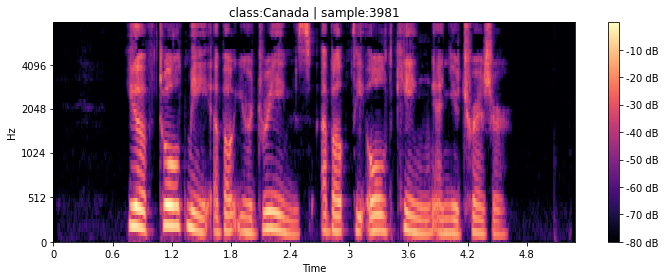

In [102]:
sample = np.random.randint(10000)
file_path = train_df['path'][sample]

y, sr = librosa.load(file_path, sr=16000)

D = np.abs(librosa.stft(y, n_fft=512, hop_length=160))**2
S = librosa.feature.melspectrogram(S=D, sr=sr, n_mels=64)
print(S.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', sr=16000, hop_length=160, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f"class:{train_df['accent'][sample]} | sample:{sample}")
plt.tight_layout()
plt.show()

## Time-Masking

In [103]:
import torch
import torchaudio
import torchaudio.transforms as T

In [104]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

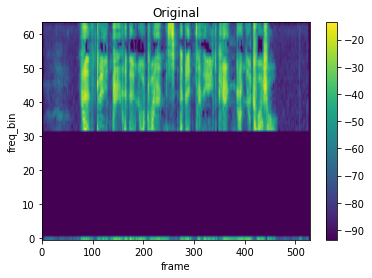

In [113]:
tS = torch.tensor(S).unsqueeze(0)
FrequencyMasking =  T.FrequencyMasking(freq_mask_param=128)

output = FrequencyMasking(tS)

plot_spectrogram(output[0], title="Original")

In [137]:
output[0].shape

torch.Size([64, 668])

In [268]:
output

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.7525e-04,
          1.0152e-03, 3.3566e-04],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1474e-03,
          7.0008e-04, 1.8950e-04],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4337e-04,
          3.8290e-04, 3.0227e-05],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.3969e-07,
          2.3184e-07, 1.1860e-07],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.2061e-08,
          1.2096e-07, 6.8299e-08],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 7.2207e-09,
          2.0422e-08, 2.0147e-08]]])

In [280]:
import torchvision
transform = torchvision.transforms.ToTensor()

In [287]:
torchaudio.load(train_df['path'][0])[0].shape

torch.Size([1, 346752])

In [293]:
a.shape

(1, 64, 613)

In [292]:
a = librosa.power_to_db(output, ref=np.max)

In [294]:
min_level_db = -80
norm_log_S = np.clip((a -min_level_db) / -min_level_db, 0, 1)

In [295]:
norm_log_S.shape

(1, 64, 613)

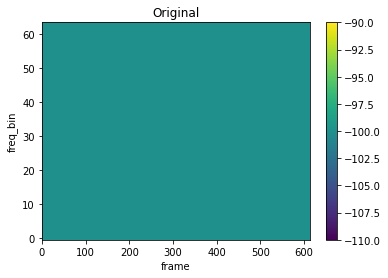

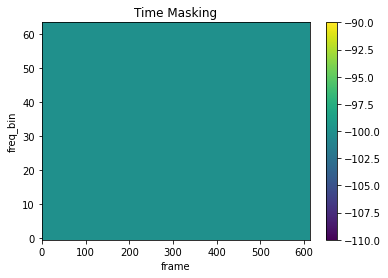

In [261]:
tS = torch.tensor(S.copy()).unsqueeze(0)
plot_spectrogram(tS[0], title="Original")

masking =  T.TimeMasking(time_mask_param=20)
output = masking(tS)

plot_spectrogram(output[0], title="Time Masking")

# Preprocessing

In [140]:
file_path = train_df['path'][0]
audio, sample_rate = librosa.load(file_path)

In [162]:
%%time

joblib.dump(audio, os.path.join(data_dir,'sample.npy'))
data = joblib.load(os.path.join(data_dir,'sample.npy'))

CPU times: user 0 ns, sys: 2.83 ms, total: 2.83 ms
Wall time: 1.96 ms


In [163]:
%%time 

np.save(os.path.join(data_dir,'sample'), audio)
data = np.load(os.path.join(data_dir,'sample.npy'))

CPU times: user 2.72 ms, sys: 0 ns, total: 2.72 ms
Wall time: 1.87 ms


I/O 과정에서 속도 차이는 크게 나지 않지만 조금 더 빠른 npy형태로 저장하였음.

In [113]:
os.makedirs('./dataset/train_npy', exist_ok=True)
os.makedirs('./dataset/test_npy', exist_ok=True)

train_npy_dir = './dataset/train_npy'
test_npy_dir = './dataset/test_npy'

In [151]:
for accent in train_df['accent'].unique():
    train_files = glob(os.path.join(train_data_dir, accent.lower(), '*.wav'))
    
    if not os.path.exists(os.path.join(train_npy_dir, accent.lower())):
        os.makedirs(os.path.join(train_npy_dir, accent.lower()), exist_ok=True)
        
    for i in tqdm(train_files):
        wav, _ = librosa.load(i, sr=16000)
        wav_name = i.split('/')[-1].split('.')[0]
        np.save(os.path.join(train_npy_dir, accent.lower(), wav_name), wav)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1020 [00:00<?, ?it/s]

In [164]:
train_df.head()

,id,accent,path
0,common_voice_en_10047.wav,Africa,./dataset/train/africa/common_voice_en_10047.wav
1,common_voice_en_10048.wav,Africa,./dataset/train/africa/common_voice_en_10048.wav
2,common_voice_en_10049.wav,Africa,./dataset/train/africa/common_voice_en_10049.wav
3,common_voice_en_10050.wav,Africa,./dataset/train/africa/common_voice_en_10050.wav
4,common_voice_en_10051.wav,Africa,./dataset/train/africa/common_voice_en_10051.wav


In [165]:
train_df['id'] = train_df['id'].map(lambda x: re.sub('wav', 'npy', x))
train_df['path'] = train_df['path'].map(lambda x: re.sub('wav', 'npy', x))
train_df['path'] = train_df['path'].map(lambda x: re.sub('train', 'train_npy', x))

In [166]:
train_df.head()

,id,accent,path
0,common_voice_en_10047.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
1,common_voice_en_10048.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
2,common_voice_en_10049.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
3,common_voice_en_10050.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
4,common_voice_en_10051.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...


In [167]:
train_df.to_csv(os.path.join(data_dir, 'new_train.csv'), index=False)

In [169]:
test_files = glob(os.path.join(test_data_dir, '*.wav'))

test_df = pd.DataFrame(index = range(len(test_files)), columns = ['path'])
test_df['path'] = test_files
test_df['id'] = test_df['path'].apply(lambda x: int(re.findall('[0-9]+', x.split('/')[-1])[0]))
test_df = test_df.sort_values(by='id').reset_index(drop=True)

In [170]:
test_df.head()

,path,id
0,./dataset/test/1.wav,1
1,./dataset/test/2.wav,2
2,./dataset/test/3.wav,3
3,./dataset/test/4.wav,4
4,./dataset/test/5.wav,5


In [172]:
for i in tqdm(test_files):
    wav, _ = librosa.load(i, sr=16000)
    wav_name = i.split('/')[-1].split('.')[0]
    np.save(os.path.join(test_npy_dir, wav_name), wav)

  0%|          | 0/6100 [00:00<?, ?it/s]

In [173]:
test_df['path'] = test_df['path'].map(lambda x: re.sub('wav', 'npy', x))
test_df['path'] = test_df['path'].map(lambda x: re.sub('test', 'test_npy', x))

In [174]:
test_df.to_csv(os.path.join(data_dir, 'test.csv'), index=False)

# Extract Featrues

In [175]:
train_df = pd.read_csv(os.path.join(data_dir, 'new_train.csv'))
train_df.head()

,id,accent,path
0,common_voice_en_10047.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
1,common_voice_en_10048.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
2,common_voice_en_10049.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
3,common_voice_en_10050.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...
4,common_voice_en_10051.npy,Africa,./dataset/train_npy/africa/common_voice_en_100...


In [200]:
def features_extractor(file_name, n_mfcc, sr=16000):
    audio = np.load(file_name)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [203]:
train_df['feature'] = train_df['path'].map(lambda x: features_extractor(x, 40))

In [205]:
test_df['feature'] = test_df['path'].map(lambda x: features_extractor(x, 40))

In [212]:
train_df.to_pickle(os.path.join(data_dir, 'new_train.pkl'))
test_df.to_pickle(os.path.join(data_dir, 'test.pkl'))

In [208]:
le = sklearn.preprocessing.LabelEncoder()

train_df['accent'] = le.fit_transform(train_df['accent'])

In [217]:
X_train = np.array(train_df['feature'].to_list())
Y_train = np.array(train_df['accent'].to_list())

X_test = np.array(test_df['feature'].to_list())

In [238]:
param = {'boosting_type':'gbdt',
         'max_depth':6, 
         'num_leaves':31,
         'metric': 'multi_logloss',
         'n_estimators':10000, 
         'learning_rate':0.01, 
         'subsample':0.7, 
         'colsample_bytree':0.7,
         'random_state':42
        }

In [239]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

oof_lgb = np.zeros((len(train_df), 6))
lgb_pred = np.zeros((len(test_df), 6))

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(X_train, Y_train)):
    print("\nfold num_: {}".format(fold_))
    trn_y, val_y = Y_train[trn_idx], Y_train[val_idx]
    trn_x, val_x = X_train[trn_idx], X_train[val_idx]
    
    clf = LGBMClassifier(**param)
    clf.fit(trn_x, trn_y, 
            eval_set=[(trn_x, trn_y), (val_x, val_y)], 
            early_stopping_rounds=50,
            verbose=100)
    
    oof_lgb[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)   
    lgb_pred += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)

lgb_pred /= 5    
print('\nCross Validation Is Complete')
print("CV Accuracy score: {:<8.5f}".format(accuracy_score(Y_train, np.argmax(oof_lgb, axis=1))))
print("CV Precision score: {:<8.5f}".format(precision_score(Y_train, np.argmax(oof_lgb, axis=1), average='macro')))
print("CV Recall score: {:<8.5f}".format(recall_score(Y_train, np.argmax(oof_lgb, axis=1), average='macro')))
print("CV F1 score: {:<8.5f}".format(f1_score(Y_train, np.argmax(oof_lgb, axis=1), average='macro')))
print("CV Log-Loss score: {:<8.5f}".format(log_loss(Y_train, oof_lgb)))


fold num_: 0
Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 1.00696	valid_1's multi_logloss: 1.08577
[200]	training's multi_logloss: 0.856201	valid_1's multi_logloss: 0.981524
[300]	training's multi_logloss: 0.762776	valid_1's multi_logloss: 0.920599
[400]	training's multi_logloss: 0.694268	valid_1's multi_logloss: 0.877808
[500]	training's multi_logloss: 0.639647	valid_1's multi_logloss: 0.845688
[600]	training's multi_logloss: 0.592418	valid_1's multi_logloss: 0.819608
[700]	training's multi_logloss: 0.552064	valid_1's multi_logloss: 0.797791
[800]	training's multi_logloss: 0.516652	valid_1's multi_logloss: 0.779271
[900]	training's multi_logloss: 0.48349	valid_1's multi_logloss: 0.760586
[1000]	training's multi_logloss: 0.453512	valid_1's multi_logloss: 0.745073
[1100]	training's multi_logloss: 0.425432	valid_1's multi_logloss: 0.730429
[1200]	training's multi_logloss: 0.400644	valid_1's multi_logloss: 0.717883
[1300]	training's multi_l

KeyboardInterrupt: 

In [233]:
sub_df.iloc[:, 1:] = lgb_pred

In [236]:
sub_df.to_csv('./infer/lgb_baseline.csv', index=False)